# Massey's Method

Massey's Method refers to Kenneth Massey's method for ranking sport teams. Denote the following.

- $n$ is the number of teams
- $m$ is the number games played (only 2 teams can play in a game)
- $X$ is a $n$ x $m$ matrix where columns corresponding to teams and rows correspond to games
  - Each row of $X$ is sparse (mostly zeros)
  - For each row, 1 is placed in the column corresponding to the winning team
  - For each row, -1 is placed in the column corresponding to the losing team
- $r$ is a $n$ x 1 vector corresponding to the `rating` of each team
  - $r$ is what will be estimated 
- $y$ is a $n$ x 1 vector corresponding to the margins of victory

Then, we are trying to solve

$Xr = y$

Futhermore, denote coefficient matrix $M$ as $M = X^TX$. Thus, $M$ will be $n$ x $n$ and 

- the diagonal elements $M_{ii}$ of $M$ will be the number of games played by the i-th team,
- the off-diagonal elements $M_{ij}$ will be the negation of the number of times the i-th team played the j-th team.

Instead of solving $Xr = y$, then we can solve the following,

$Mr = p$,

where $p = X^Ty$.

## Data

Let's illustrate Massey's Method using data from the NCAAF ACC conference for the year 2005. Below, `t1` and `t2` are the 2 teams playing and `s1` and `s2` are the scores corresponding to `t1` and `t2`. There is no information on who was at home or away.

In [1]:
import pandas as pd

f_df = pd.read_csv('./ranking/acc-2005-ncaaf.csv')
f_df

,t1,t2,s1,s2
0,Duke,Miami,7,52
1,Duke,UNC,21,24
2,Duke,UVA,7,38
3,Duke,VT,0,45
4,Miami,UNC,34,16
5,Miami,UVA,25,17
6,Miami,VT,27,7
7,UNC,UVA,7,5
8,UNC,VT,3,30
9,UVA,VT,14,52


We can swap the teams and scores and get a view like the following.

In [2]:
r_df = pd.DataFrame([{'t1': r.t2, 't2': r.t1, 's1': r.s2, 's2': r.s1} for _, r in f_df.iterrows()])

game_df = pd.concat([f_df, r_df]).reset_index(drop=True)
game_df['differential'] = game_df.s1 - game_df.s2
game_df.sort_values(['t1', 't2'])

,t1,t2,s1,s2,differential
0,Duke,Miami,7,52,-45
1,Duke,UNC,21,24,-3
2,Duke,UVA,7,38,-31
3,Duke,VT,0,45,-45
10,Miami,Duke,52,7,45
4,Miami,UNC,34,16,18
5,Miami,UVA,25,17,8
6,Miami,VT,27,7,20
11,UNC,Duke,24,21,3
14,UNC,Miami,16,34,-18


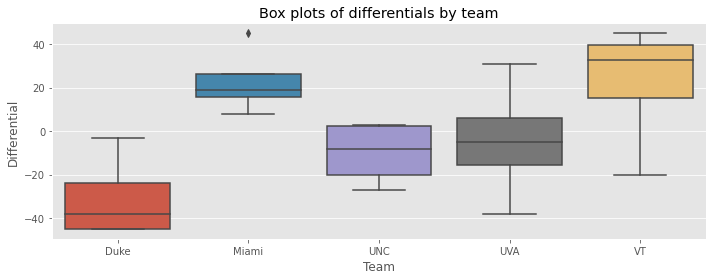

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 4))

_ = sns.boxplot(x='t1', y='differential', data=game_df, ax=ax)
_ = ax.set_title('Box plots of differentials by team')
_ = ax.set_xlabel('Team')
_ = ax.set_ylabel('Differential')

plt.tight_layout()

## Ranking from ratings

A $n$ x $n$ matrix of point differential for each team can be created as follows. In the matrix below, UNC 

- won Duke by 3 points,
- lost to Miami by 18 points,
- win UVA by 2 points, and
- lost to VT by 27 points.

When a team wins, the number in this matrix is positive, and when a team loses, the number in this matrix is negative.

In [4]:
import numpy as np

def get_differential(t1, t2):
    if t1 == t2:
        return np.nan
    s = game_df[(game_df.t1 == t1) & (game_df.t2 == t2)].iloc[0]
    return s.s1 - s.s2

teams = sorted(list(set(game_df.t1) | set(game_df.t2)))
differentials = [[get_differential(t1, t2) for t2 in teams] for t1 in teams]

diff_df = pd.DataFrame(differentials, index=teams, columns=teams)
diff_df

,Duke,Miami,UNC,UVA,VT
Duke,NaN,-45.0,-3.0,-31.0,-45.0
Miami,45.0,NaN,18.0,8.0,20.0
UNC,3.0,-18.0,NaN,2.0,-27.0
UVA,31.0,-8.0,-2.0,NaN,-38.0
VT,45.0,-20.0,27.0,38.0,NaN


From this point differential matrix, we can then compute the total point differential (sum across the columns) and the number of wins (positive scores) and losses (negative scores).

In [5]:
stat_df = pd.DataFrame({
    'differential': diff_df.sum(axis=1),
    'wins': diff_df.apply(lambda r: len(r[r > 0]), axis=1),
    'losses': diff_df.apply(lambda r: len(r[r < 0]), axis=1)
})

stat_df

,differential,wins,losses
Duke,-124.0,0,4
Miami,91.0,4,0
UNC,-40.0,2,2
UVA,-17.0,1,3
VT,90.0,3,1


If we let the sum of the point differentials be the ratings, then the ranking produced is as follows where Miami is first and Duke is last.

In [6]:
stat_df.differential.sort_values(ascending=False)

Miami     91.0
VT        90.0
UVA      -17.0
UNC      -40.0
Duke    -124.0
Name: differential, dtype: float64

We can also let the number of wins be the ratings, and Miami is still first and Duke is last.

In [7]:
stat_df.wins.sort_values(ascending=False)

Miami    4
VT       3
UNC      2
UVA      1
Duke     0
Name: wins, dtype: int64

Let's compare the ranking by point differential and wins. Notice that the rankings are nearly identical, except that UVA and UNC switch places?

In [8]:
pd.DataFrame({
    'by_differential': stat_df.differential.sort_values(ascending=False).index,
    'by_wins': stat_df.wins.sort_values(ascending=False).index
})

,by_differential,by_wins
0,Miami,Miami
1,VT,VT
2,UVA,UNC
3,UNC,UVA
4,Duke,Duke


## Xr = y

Let's build or $X$ matrix.

In [9]:
def get_vector(r):
    v = [0 for i in range(len(teams))]
    
    if r.s1 > r.s2:
        v[t2i[r.t1]] = 1
        v[t2i[r.t2]] = -1
    else:
        v[t2i[r.t1]] = -1
        v[t2i[r.t2]] = 1
    return v
        
t2i = {t: i for i, t in enumerate(teams)}

X = pd.DataFrame([get_vector(r) for _, r in f_df.iterrows()], columns=teams)
X

,Duke,Miami,UNC,UVA,VT
0,-1,1,0,0,0
1,-1,0,1,0,0
2,-1,0,0,1,0
3,-1,0,0,0,1
4,0,1,-1,0,0
5,0,1,0,-1,0
6,0,1,0,0,-1
7,0,0,1,-1,0
8,0,0,-1,0,1
9,0,0,0,-1,1


Notice that $X^TX = M$. 

In [10]:
X.T.dot(X)

,Duke,Miami,UNC,UVA,VT
Duke,4,-1,-1,-1,-1
Miami,-1,4,-1,-1,-1
UNC,-1,-1,4,-1,-1
UVA,-1,-1,-1,4,-1
VT,-1,-1,-1,-1,4


Our $y$ will be the point differential.

In [11]:
y = f_df.s1 - f_df.s2
y

0   -45
1    -3
2   -31
3   -45
4    18
5     8
6    20
7     2
8   -27
9   -38
dtype: int64

We will not attempt to learn the ratings using linear regression. 

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
model.intercept_, model.coef_

(4.100000000000035, array([ 28.08,  -3.08,   1.6 ,   1.04, -27.64]))

The ratings are the coefficients (see below where we negate them). However, because $m >> n$, the linear system is highly overdetermined and inconsistent.

In [13]:
sorted(list(zip(teams, -model.coef_)), key=lambda tup: tup[1], reverse=True)

[('VT', 27.640000000000022),
 ('Miami', 3.080000000000026),
 ('UVA', -1.0400000000000234),
 ('UNC', -1.5999999999999974),
 ('Duke', -28.08000000000003)]

Note how Miami is undefeated, but still in second place? It is likely VT came in first place since their point differentials average higher. In most sports ranking system, point differentials are take out of consideration because teams with a high lead may stop scoring points as a matter of sportsmanship.

## Mr = p

Here, we will estimating the ratings and thus the ranking using the coefficient matrix $M$. 

In [14]:
def get_games_played(t1, t2):
    if t1 == t2:
        return f_df[(f_df.t1 == t1) | (f_df.t2 == t2)].shape[0]
    else:
        q1 = (f_df.t1 == t1) & (f_df.t2 == t2)
        q2 = (f_df.t1 == t2) & (f_df.t2 == t1)
        q = q1 | q2
        return -f_df[q].shape[0]

mat = [[get_games_played(t1, t2) for t2 in teams] for t1 in teams]
mat

[[4, -1, -1, -1, -1],
 [-1, 4, -1, -1, -1],
 [-1, -1, 4, -1, -1],
 [-1, -1, -1, 4, -1],
 [-1, -1, -1, -1, 4]]

To ensure that $M$ has full rank, we will convert the last row to all 1's.

In [15]:
mat[-1] = [1 for _ in range(len(mat[-1]))]
mat

[[4, -1, -1, -1, -1],
 [-1, 4, -1, -1, -1],
 [-1, -1, 4, -1, -1],
 [-1, -1, -1, 4, -1],
 [1, 1, 1, 1, 1]]

Our final $M$ looks like the following.

In [16]:
M = pd.DataFrame(mat, index=teams, columns=teams)
M

,Duke,Miami,UNC,UVA,VT
Duke,4,-1,-1,-1,-1
Miami,-1,4,-1,-1,-1
UNC,-1,-1,4,-1,-1
UVA,-1,-1,-1,4,-1
VT,1,1,1,1,1


Our $p$ looks like the following.

In [17]:
p = stat_df.differential
p

Duke    -124.0
Miami     91.0
UNC      -40.0
UVA      -17.0
VT        90.0
Name: differential, dtype: float64

Applying linear regression and sorting the ratings (coefficients), we get the final ranking below.

In [18]:
model = LinearRegression()
model.fit(M, p)
model.intercept_, model.coef_

(8.881784197001252e-15, array([-6.8, 36.2, 10. , 14.6, 36. ]))

In [19]:
sorted(list(zip(teams, model.coef_)), key=lambda tup: tup[1], reverse=True)

[('Miami', 36.2),
 ('VT', 36.00000000000002),
 ('UVA', 14.599999999999998),
 ('UNC', 9.999999999999998),
 ('Duke', -6.799999999999999)]

## NBA 2021

Let's apply Massey's Method to the NBA for the 2021 season and games up to Thanksgiving.

In [20]:
def get_nba():
    x = pd.read_csv('./nba/2021.csv')\
        .rename(columns={
            'a_team': 't1', 
            'h_team': 't2', 
            'a_score': 's1', 
            'h_score': 's2'})
    x = x[x.preseason == False]\
        .drop(columns=['preseason'])\
        .reset_index(drop=True)
    return x
    
def get_nfl():
    x = pd.read_csv('./nfl/2021.csv')\
        .rename(columns={
            'team1': 't1', 
            'team2': 't2', 
            'score1': 's1', 
            'score2': 's2'})\
        .drop(columns=['week'])
    x['t1'] = x['t1'].apply(lambda s: s.strip())
    x['t2'] = x['t2'].apply(lambda s: s.strip())
    
    return x

def get_X(df):
    def get_vector(r):
        v = [0 for i in range(len(teams))]

        if r.s1 > r.s2:
            v[t2i[r.t1]] = 1
            v[t2i[r.t2]] = -1
        else:
            v[t2i[r.t1]] = -1
            v[t2i[r.t2]] = 1
        return v

    teams = sorted(list(set(df.t1) | set(df.t2)))
    t2i = {t: i for i, t in enumerate(teams)}

    X = pd.DataFrame([get_vector(r) for _, r in df.iterrows()], columns=teams)
    X = X.T.dot(X)
    X.iloc[-1,:] = 1
    
    return X

def get_y(df):
    def get_diff(t):
        a = df[df.t1 == t]
        b = df[df.t2 == t]
        
        c = a.s1 - a.s2
        d = b.s2 - b.s1
        
        return c.sum() + d.sum()
    
    teams = sorted(list(set(df.t1) | set(df.t2)))
    diffs = [get_diff(t) for t in teams]
    
    return pd.Series(diffs, index=teams)

def get_Xy(df):
    return get_X(df), get_y(df)

In [21]:
X, y = get_Xy(get_nba())

model = LinearRegression()
model.fit(X, y)

pd.DataFrame(zip(X.index, model.coef_), columns=['Team', 'Rating'])\
    .sort_values('Rating', ascending=False)

,Team,Rating
28,Warriors,12.899850
10,Jazz,8.549796
24,Suns,6.744632
8,Heat,6.488263
16,Nets,4.254646
2,Bulls,4.235154
5,Clippers,3.792290
7,Hawks,3.338752
18,Pacers,3.138730
27,Trail Blazers,2.456361


## NFL

Let's apply Massey's Method to the NFL for the 2021 season and games up to Thanksgiving.

In [22]:
X, y = get_Xy(get_nfl())

model = LinearRegression()
model.fit(X, y)

pd.DataFrame(zip(X.index, model.coef_), columns=['Team', 'Rating'])\
    .sort_values('Rating', ascending=False)

,Team,Rating
3,Bills,8.425259
7,Cardinals,8.235687
21,Patriots,6.349719
6,Buccaneers,6.321022
11,Cowboys,5.819441
10,Colts,3.115332
9,Chiefs,2.706593
29,Titans,2.584503
23,Rams,2.472228
13,Eagles,1.696797
